In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
DecisionTreeRegressor as DTR,
plot_tree,
export_text)
from sklearn.metrics import (accuracy_score,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RF,
GradientBoostingRegressor as GBR,
GradientBoostingClassifier as GBC)
from ISLP.bart import BART
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from sklearn.cluster import \
(KMeans,
AgglomerativeClustering)
from scipy.cluster.hierarchy import \
(dendrogram,
cut_tree)
from ISLP.cluster import compute_linkage
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from ISLP import load_data, confusion_table
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from ISLP.cluster import compute_linkage
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
import time
from sklearn.impute import KNNImputer

In [581]:
data = pd.read_csv("train.csv")

Columns with NA values: ['employmentTitle', 'employmentLength', 'postCode', 'dti', 'pubRecBankruptcies', 'revolUtil', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']


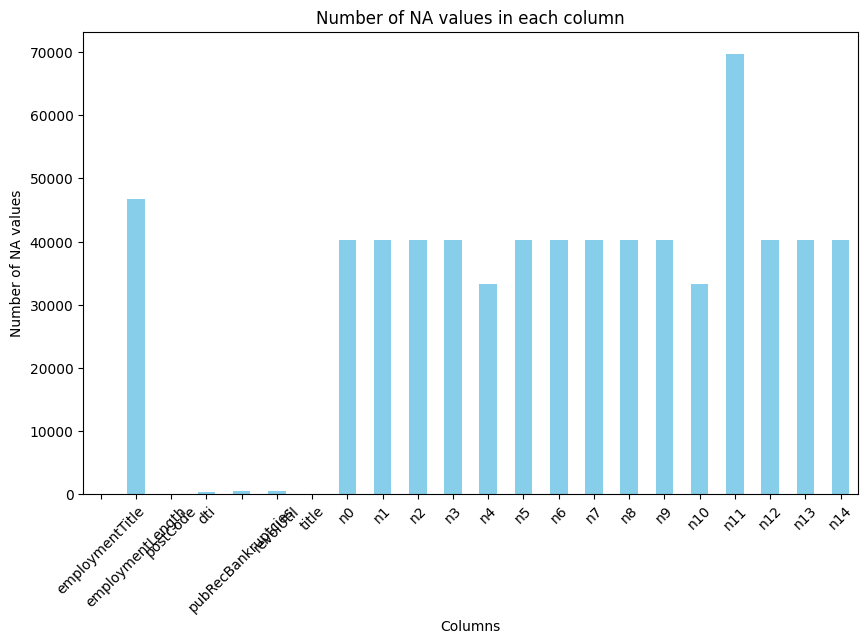

In [582]:
na_columns = data.columns[data.isna().any()].tolist()
print("Columns with NA values:", na_columns)

# Count the number of NA's in each column
na_counts = data.isna().sum()

# Filter out columns without NA's for the visualization
na_counts = na_counts[na_counts > 0]

# Plotting the histogram
plt.figure(figsize=(10, 6))
na_counts.plot(kind='bar', color='skyblue')
plt.title('Number of NA values in each column')
plt.xlabel('Columns')
plt.ylabel('Number of NA values')
plt.xticks(rotation=45)
plt.show()

In [583]:
### Transform the variable employmentLength into numerical, and replace 10years+ into 10 years, <1year into 0
data.replace({'employmentLength':{'10+ years':'10 years','< 1 year':'0.5 years'}},inplace=True)
# Define a function to extract the numerical value
def extract_years(x):
    if pd.isna(x):
        return x
    else:
        return np.float(x.split()[0])

# Apply the function to the 'employmentLength' column
data['employmentLength'] = data['employmentLength'].apply(extract_years)

/var/folders/t_/3m_6th395vn06nffphlkjwfw0000gn/T/ipykernel_14268/2652336198.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x.split()[0])


In [584]:
## drop NA's from employmentTitle, postCode, title, employmentLOength
data_cleaned = data.dropna(subset=['title','employmentTitle','employmentLength', 'postCode', 'regionCode', 'issueDate'])
data_cleaned

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5.0,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10.0,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
5,5,11000.0,3,7.99,344.65,A,A5,51727.0,7.0,0,...,1.0,48.0,2.0,3.0,2.0,19.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7.0,1,...,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
799996,799996,17000.0,3,7.90,531.94,A,A4,29205.0,10.0,0,...,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
799997,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10.0,1,...,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
799998,799998,19200.0,3,6.92,592.14,A,A4,151.0,10.0,0,...,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0


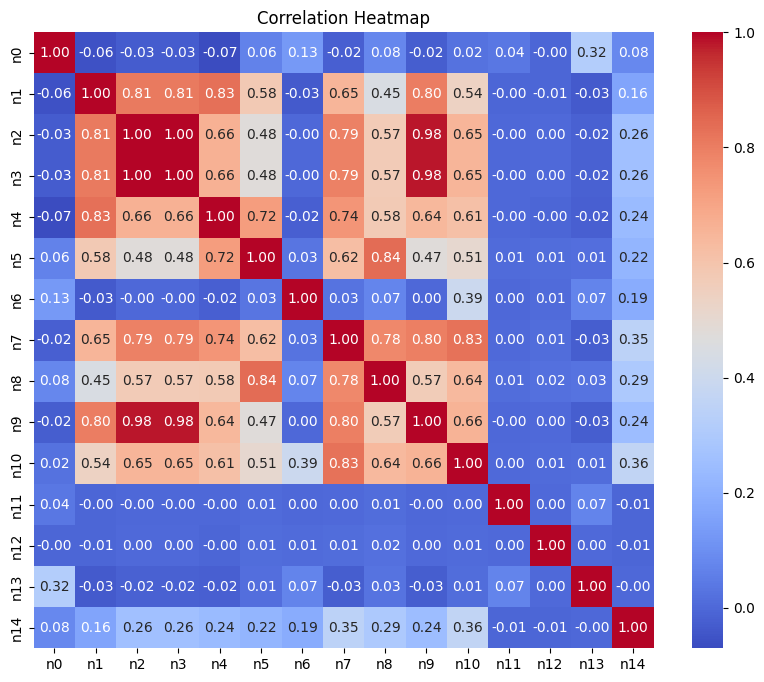

In [585]:
columns_of_interest = ['n0','n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
data_subset = data_cleaned[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = data_subset.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [444]:
# data_cleaned = data.dropna()
# data_cleaned

In [612]:
subgrade_mapping = {
    'A1': 25, 'A2': 24, 'A3': 23, 'A4': 22, 'A5': 21,
    'B1': 20, 'B2': 19, 'B3': 18, 'B4': 17, 'B5': 16,
    'C1': 15, 'C2': 14, 'C3': 13, 'C4': 12, 'C5': 11,
    'D1': 10, 'D2': 9, 'D3': 8, 'D4': 7, 'D5': 6,
    'E1': 5, 'E2': 4, 'E3': 3, 'E4': 2, 'E5': 1
}

grade_mapping = {
    'A': 5,
    'B': 4,
    'C': 3,
    'D': 2,
    'E': 1
}


In [587]:
data_cleaned['earliesCreditLine'] = data_cleaned['earliesCreditLine'].apply(lambda s: int(s[-4:]))

/var/folders/t_/3m_6th395vn06nffphlkjwfw0000gn/T/ipykernel_14268/4119927127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['earliesCreditLine'] = data_cleaned['earliesCreditLine'].apply(lambda s: int(s[-4:]))


In [588]:
### Get the label and then split the label and predictors, and drop those garbage predictors
data_cleaned = data_cleaned.dropna()

In [589]:
data_cleaned

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10.0,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
5,5,11000.0,3,7.99,344.65,A,A5,51727.0,7.0,0,...,1.0,48.0,2.0,3.0,2.0,19.0,0.0,0.0,0.0,0.0
6,6,2050.0,3,7.69,63.95,A,A4,180083.0,9.0,0,...,11.0,3.0,10.0,18.0,3.0,12.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7.0,1,...,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
799996,799996,17000.0,3,7.90,531.94,A,A4,29205.0,10.0,0,...,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
799997,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10.0,1,...,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
799998,799998,19200.0,3,6.92,592.14,A,A4,151.0,10.0,0,...,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0


In [ ]:
def feature_engineering(data_input):
    data_input['avg_income'] = data_input['annualIncome'] / data_input['employmentLength']
    data_input['avg_loanAmnt'] = data_input['loanAmnt'] / data_input['term']
    data_input['closeAcc'] = data_input['totalAcc'] - data_input['openAcc']
    data_input['duration'] = data_input['year'] - data_input['earliesCreditLine']
    data_input['avg_interest_rate'] = data_input['interestRate']/data_input['term']
    data_input['install_num_year'] = data_input['loanAmnt']/(data_input['term'] * data_input['installment'])
    data_input['in_loan_rate'] = data_input['avg_income']/data_input['avg_loanAmnt']
    data_input['rest_money'] = data_input['annualIncome'] - data_input['avg_loanAmnt']
    data_input['ficoRange_mean'] = (data_input['ficoRangeHigh'] + data_input['ficoRangeLow']) / 2

    data_input['rest_pubRec'] = data_input['pubRec'] - data_input['pubRecBankruptcies']
    data_input['rest_Revol'] = data_input['loanAmnt'] - data_input['revolBal']
    del data_input['interestRate'], data_input['ficoRangeHigh'], data_input['ficoRangeLow']


    data_output = data_input
    return data_output

In [590]:
### get the 14 anonamous variables n1-n14
ano_vars = data_cleaned.iloc[:, -15:]
ano_vars

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
2,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
5,12.0,1.0,2.0,2.0,1.0,1.0,48.0,2.0,3.0,2.0,19.0,0.0,0.0,0.0,0.0
6,0.0,1.0,3.0,3.0,7.0,11.0,3.0,10.0,18.0,3.0,12.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.0,5.0,10.0,10.0,6.0,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
799996,0.0,2.0,2.0,2.0,2.0,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
799997,2.0,1.0,4.0,4.0,1.0,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
799998,0.0,5.0,8.0,8.0,7.0,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0


In [591]:
### get the left dataframe with left 26 variables
other_vars = data_cleaned.iloc[:, :-15]
other_vars

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,...,0.0,0.0,24178.0,48.9,27.0,0,0,2001,1.0,1.0
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,...,0.0,0.0,4606.0,51.8,27.0,0,0,2006,0.0,1.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10.0,1,...,0.0,0.0,9948.0,52.6,28.0,1,0,1999,4.0,1.0
5,5,11000.0,3,7.99,344.65,A,A5,51727.0,7.0,0,...,0.0,0.0,4047.0,31.1,52.0,1,0,1998,10.0,1.0
6,6,2050.0,3,7.69,63.95,A,A4,180083.0,9.0,0,...,0.0,0.0,3111.0,8.5,23.0,0,0,2006,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7.0,1,...,0.0,0.0,9933.0,46.4,15.0,1,0,2011,0.0,1.0
799996,799996,17000.0,3,7.90,531.94,A,A4,29205.0,10.0,0,...,0.0,0.0,20472.0,98.4,42.0,0,0,1989,33369.0,1.0
799997,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10.0,1,...,0.0,0.0,6381.0,51.9,36.0,1,0,2002,0.0,1.0
799998,799998,19200.0,3,6.92,592.14,A,A4,151.0,10.0,0,...,0.0,0.0,69702.0,61.3,37.0,1,0,1994,4.0,1.0


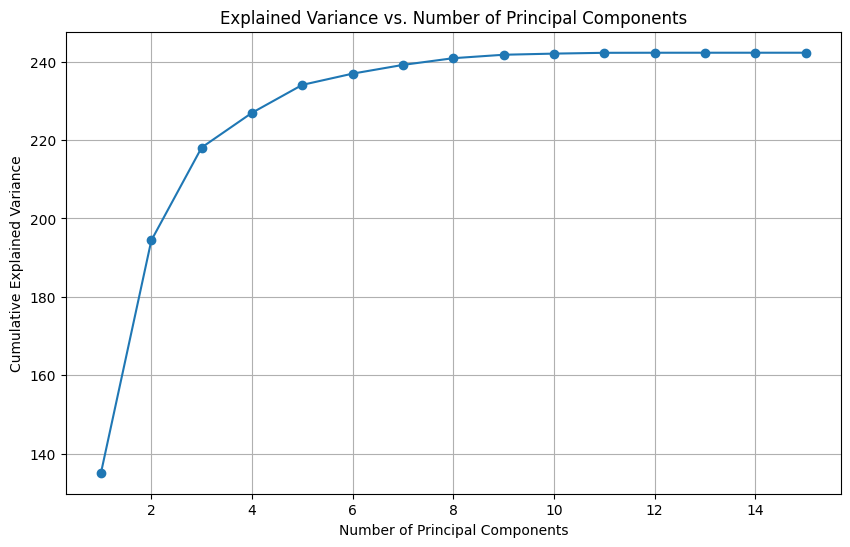

In [592]:
## Standardize the anonomous data n1-n14
scaler = StandardScaler()
ano_vars_scaled = scaler.fit_transform(ano_vars)

## Perform PCA
pca = PCA()
ano_vars_pca = pca.fit_transform(ano_vars)

## Determine the optimal number of principle components
explained_variance = pca.explained_variance_.cumsum()

##
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()


In [593]:
explained_variance

array([135.13604059, 194.40221807, 218.10815977, 226.96283705,
       234.08862262, 236.9564261 , 239.18411621, 240.89644662,
       241.77315117, 242.06297147, 242.2689708 , 242.28621482,
       242.29017632, 242.29108432, 242.29108432])

In [594]:
## We choose 7 principle components
k = 7

## Get the first k principle components
ano_vars_pca_k = ano_vars_pca[:, :k]

## Create a new dataframe for the PC
pca_columns = [f'PC{i+1}' for i in range(k)]
ano_vars_pca_df = pd.DataFrame(ano_vars_pca_k, columns=pca_columns)

In [595]:
## Get the final dataframe with PCA resulted dataframe
data_cleaned = pd.concat([other_vars.reset_index(drop=True), 
                      ano_vars_pca_df.reset_index(drop=True)], axis=1)

In [596]:
data_cleaned

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,earliesCreditLine,title,policyCode,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2.0,2,...,2001,1.0,1.0,-7.323829,-0.316382,5.455968,-1.501671,1.662497,0.354413,0.060289
1,2,12000.0,5,16.99,298.17,D,D3,31698.0,8.0,0,...,2006,0.0,1.0,-11.696284,14.928737,-1.976130,2.863187,-2.054730,1.649645,-0.108874
2,3,11000.0,3,7.26,340.96,A,A4,46854.0,10.0,1,...,1999,4.0,1.0,4.808308,-6.683777,6.898708,-4.248859,-0.992539,-0.469341,-3.848580
3,5,11000.0,3,7.99,344.65,A,A5,51727.0,7.0,0,...,1998,10.0,1.0,-7.069570,42.722212,-1.637167,-0.299728,-0.071150,-2.099269,-3.899337
4,6,2050.0,3,7.69,63.95,A,A4,180083.0,9.0,0,...,2006,0.0,1.0,1.722401,-5.879873,4.885649,2.655484,3.981959,0.953263,1.110784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686190,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7.0,1,...,2011,0.0,1.0,2.947986,-6.905784,-8.722383,0.806907,-1.350804,0.742364,-0.130304
686191,799996,17000.0,3,7.90,531.94,A,A4,29205.0,10.0,0,...,1989,33369.0,1.0,-0.991242,5.960144,12.691543,-5.131494,-0.628779,-2.156080,-1.482794
686192,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10.0,1,...,2002,0.0,1.0,-7.973196,17.143006,3.082819,-3.482622,-5.879139,3.012769,2.118117
686193,799998,19200.0,3,6.92,592.14,A,A4,151.0,10.0,0,...,1994,4.0,1.0,10.372923,-3.930178,-0.827217,1.732005,-0.314496,2.010363,-0.285373


In [597]:
data_cleaned['issueDate'] = pd.to_datetime(data_cleaned['issueDate'])
data_cleaned['year'] = data_cleaned['issueDate'].dt.year
data_cleaned['interestRate_bin'] = pd.qcut(data_cleaned['interestRate'], 10, labels=[0,1,2,3,4,5,6,7,8,9], duplicates='drop')

In [16]:
# KNN Imputer
# knn_imputer = KNNImputer(n_neighbors=20)
# data_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(data_cleaned), columns=data_cleaned.columns)
# print("Data after KNN Imputation:\n", data_knn_imputed)
# data_knn_imputed.to_csv('filled_data.csv')

In [18]:
# def impute_chunk(chunk, n_neighbors=20):
#     imputer = KNNImputer(n_neighbors=n_neighbors)
#     return imputer.fit_transform(chunk)



# def split_data(data, n_chunks):
#     chunk_size = int(np.ceil(len(data) / n_chunks))
#     return [data[i*chunk_size:(i+1)*chunk_size] for i in range(n_chunks)]

# # Number of chunks for parallel processing
# n_chunks = 8

# # Split the dataset into chunks
# chunks = split_data(data_cleaned, n_chunks)

# # Impute each chunk in parallel
# imputed_chunks = Parallel(n_jobs=-1)(delayed(impute_chunk)(chunk) for chunk in chunks)

# # Combine the imputed chunks back into a single dataset
# imputed_data = np.vstack(imputed_chunks)

# # Convert the result back to a DataFrame
# imputed_df = pd.DataFrame(imputed_data, columns=data_cleaned.columns)

# imputed_df.to_csv('filled_data.csv')

In [598]:
label = data_cleaned['isDefault']
data_cleaned = data_cleaned.drop(columns = ['id', 'title', 'policyCode', 'isDefault', 'employmentTitle', 'postCode', 'issueDate'])

In [599]:
# Fill NA's with mean
data_cleaned

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,...,earliesCreditLine,PC1,PC2,PC3,PC4,PC5,PC6,PC7,year,interestRate_bin
0,35000.0,5,19.52,917.97,E,E2,2.0,2,110000.0,2,...,2001,-7.323829,-0.316382,5.455968,-1.501671,1.662497,0.354413,0.060289,2014,8
1,12000.0,5,16.99,298.17,D,D3,8.0,0,74000.0,2,...,2006,-11.696284,14.928737,-1.976130,2.863187,-2.054730,1.649645,-0.108874,2015,7
2,11000.0,3,7.26,340.96,A,A4,10.0,1,118000.0,1,...,1999,4.808308,-6.683777,6.898708,-4.248859,-0.992539,-0.469341,-3.848580,2015,0
3,11000.0,3,7.99,344.65,A,A5,7.0,0,39000.0,2,...,1998,-7.069570,42.722212,-1.637167,-0.299728,-0.071150,-2.099269,-3.899337,2017,1
4,2050.0,3,7.69,63.95,A,A4,9.0,0,35000.0,0,...,2006,1.722401,-5.879873,4.885649,2.655484,3.981959,0.953263,1.110784,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686190,25000.0,3,14.49,860.41,C,C4,7.0,1,72000.0,0,...,2011,2.947986,-6.905784,-8.722383,0.806907,-1.350804,0.742364,-0.130304,2016,6
686191,17000.0,3,7.90,531.94,A,A4,10.0,0,99000.0,2,...,1989,-0.991242,5.960144,12.691543,-5.131494,-0.628779,-2.156080,-1.482794,2013,1
686192,6000.0,3,13.33,203.12,C,C3,10.0,1,65000.0,2,...,2002,-7.973196,17.143006,3.082819,-3.482622,-5.879139,3.012769,2.118117,2015,5
686193,19200.0,3,6.92,592.14,A,A4,10.0,0,96000.0,2,...,1994,10.372923,-3.930178,-0.827217,1.732005,-0.314496,2.010363,-0.285373,2015,0


## Feature Engnieering

In [613]:
def feature_engineering(data_input):
    data_input['avg_income'] = data_input['annualIncome'] / data_input['employmentLength']
    data_input['avg_loanAmnt'] = data_input['loanAmnt'] / data_input['term']
    data_input['closeAcc'] = data_input['totalAcc'] - data_input['openAcc']
    data_input['duration'] = data_input['year'] - data_input['earliesCreditLine']
    data_input['avg_interest_rate'] = data_input['interestRate']/data_input['term']
    data_input['install_num_year'] = data_input['loanAmnt']/(data_input['term'] * data_input['installment'])
    data_input['in_loan_rate'] = data_input['avg_income']/data_input['avg_loanAmnt']
    data_input['rest_money'] = data_input['annualIncome'] - data_input['avg_loanAmnt']
    data_input['ficoRange_mean'] = (data_input['ficoRangeHigh'] + data_input['ficoRangeLow']) / 2

    data_input['rest_pubRec'] = data_input['pubRec'] - data_input['pubRecBankruptcies']
    data_input['rest_Revol'] = data_input['loanAmnt'] - data_input['revolBal']
    del data_input['interestRate'], data_input['ficoRangeHigh'], data_input['ficoRangeLow']


    data_output = data_input
    return data_output

In [614]:
data_gbm = feature_engineering(data_cleaned.copy())

In [615]:
data_gbm['subGrade'] = data_gbm['subGrade'].map(subgrade_mapping)
data_gbm['grade'] = data_gbm['grade'].map(grade_mapping)

In [616]:
data_gbm

,loanAmnt,term,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,...,avg_loanAmnt,closeAcc,duration,avg_interest_rate,install_num_year,in_loan_rate,rest_money,ficoRange_mean,rest_pubRec,rest_Revol
0,35000.0,5,917.97,1.0,4.0,2.0,2,110000.0,2,1,...,7000.000000,20.0,13,3.904000,7.625522,7.857143,103000.000000,732.0,0.0,10822.0
1,12000.0,5,298.17,2.0,8.0,8.0,0,74000.0,2,0,...,2400.000000,16.0,9,3.398000,8.049100,3.854167,71600.000000,677.0,0.0,7394.0
2,11000.0,3,340.96,5.0,22.0,10.0,1,118000.0,1,4,...,3666.666667,19.0,16,2.420000,10.753950,3.218182,114333.333333,687.0,0.0,1052.0
3,11000.0,3,344.65,5.0,21.0,7.0,0,39000.0,2,9,...,3666.666667,33.0,19,2.663333,10.638812,1.519481,35333.333333,732.0,0.0,6953.0
4,2050.0,3,63.95,5.0,22.0,9.0,0,35000.0,0,0,...,683.333333,11.0,8,2.563333,10.685431,5.691057,34316.666667,757.0,0.0,-1061.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686190,25000.0,3,860.41,3.0,12.0,7.0,1,72000.0,0,0,...,8333.333333,1.0,5,4.830000,9.685305,1.234286,63666.666667,712.0,0.0,15067.0
686191,17000.0,3,531.94,5.0,22.0,10.0,0,99000.0,2,4,...,5666.666667,35.0,24,2.633333,10.652831,1.747059,93333.333333,722.0,0.0,-3472.0
686192,6000.0,3,203.12,3.0,13.0,10.0,1,65000.0,2,0,...,2000.000000,31.0,13,4.443333,9.846396,3.250000,63000.000000,672.0,0.0,-381.0
686193,19200.0,3,592.14,5.0,22.0,10.0,0,96000.0,2,4,...,6400.000000,21.0,21,2.306667,10.808255,1.500000,89600.000000,677.0,0.0,-50502.0


## LightGBM

In [617]:
def lightgbm(data, test_size, random_state, learning_rate, max_depth, num_leaves, num_round):
    categorical_features = ['homeOwnership', 'verificationStatus', 'purpose', 'regionCode', 'duration', 'earliesCreditLine']
    ### transform specific variables into categorical variables
    for col in categorical_features:
        data[col] = data[col].astype('category')
    
    ### Split data into training set and test set
    X_train, X_test, y_train, y_test = skm.train_test_split(data, label, test_size = test_size, 
                                                       random_state = random_state, stratify = label)
    
    ### Implement lgb
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'verbose': -1,
        'num_leaves': num_leaves,
        'bagging_fraction': [0.9],
        'feature_fraction': [0.8],
        'nthread': [4],
        'min_gain_to_split': [0],
        'lambda_l1': [0.3],
        'lambda_l2': [0.5],
        'min_data_in_leaf': [50]
    }

    num_round = num_round
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

    # Make predictions
    y_pred_proba = bst.predict(X_test, num_iteration=bst.best_iteration,)
    y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]

    # Evaluate the model
    # accuracy = accuracy_score(y_test, y_pred)
    # elapsed_time = end_time - start_time
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return auc

In [618]:
data_gbm

,loanAmnt,term,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,...,avg_loanAmnt,closeAcc,duration,avg_interest_rate,install_num_year,in_loan_rate,rest_money,ficoRange_mean,rest_pubRec,rest_Revol
0,35000.0,5,917.97,1.0,4.0,2.0,2,110000.0,2,1,...,7000.000000,20.0,13,3.904000,7.625522,7.857143,103000.000000,732.0,0.0,10822.0
1,12000.0,5,298.17,2.0,8.0,8.0,0,74000.0,2,0,...,2400.000000,16.0,9,3.398000,8.049100,3.854167,71600.000000,677.0,0.0,7394.0
2,11000.0,3,340.96,5.0,22.0,10.0,1,118000.0,1,4,...,3666.666667,19.0,16,2.420000,10.753950,3.218182,114333.333333,687.0,0.0,1052.0
3,11000.0,3,344.65,5.0,21.0,7.0,0,39000.0,2,9,...,3666.666667,33.0,19,2.663333,10.638812,1.519481,35333.333333,732.0,0.0,6953.0
4,2050.0,3,63.95,5.0,22.0,9.0,0,35000.0,0,0,...,683.333333,11.0,8,2.563333,10.685431,5.691057,34316.666667,757.0,0.0,-1061.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686190,25000.0,3,860.41,3.0,12.0,7.0,1,72000.0,0,0,...,8333.333333,1.0,5,4.830000,9.685305,1.234286,63666.666667,712.0,0.0,15067.0
686191,17000.0,3,531.94,5.0,22.0,10.0,0,99000.0,2,4,...,5666.666667,35.0,24,2.633333,10.652831,1.747059,93333.333333,722.0,0.0,-3472.0
686192,6000.0,3,203.12,3.0,13.0,10.0,1,65000.0,2,0,...,2000.000000,31.0,13,4.443333,9.846396,3.250000,63000.000000,672.0,0.0,-381.0
686193,19200.0,3,592.14,5.0,22.0,10.0,0,96000.0,2,4,...,6400.000000,21.0,21,2.306667,10.808255,1.500000,89600.000000,677.0,0.0,-50502.0


In [619]:
auc = lightgbm(data_gbm, test_size = 0.1, random_state = 100, learning_rate = 0.012, max_depth = 4,
        num_leaves = 50, num_round = 2500)
auc

0.734494041454347

## GridSearch

In [331]:
model = lgb.LGBMClassifier()

param_grid = {
    'learning_rate': np.linspace(0.006, 0.028, 8),
    'max_depth': [4],
    'n_estimators': [2500],
    'bagging_fraction': [0.95],
    'min_gain_to_split': [0],
    'min_data_in_leaf': [30],
    'lambda_l1': [1],
    'lambda_l2': [2],
    'feature_fraction': [0.85],
    'num_leaves': [30]
}

In [380]:
categorical_features = ['homeOwnership', 'verificationStatus', 'purpose', 'regionCode', 'earliesCreditLine', 'duration']

In [381]:
for col in categorical_features:
    data_gbm[col] = data_gbm[col].astype('category')

In [382]:
data_gbm

,loanAmnt,term,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,...,closeAcc,duration,avg_term,avg_interest_rate,install_num_year,in_loan_rate,rest_money,ficoRange_mean,rest_pubRec,rest_Revol
0,35000.0,5,917.97,0.0,8.0,2.0,2,110000.0,2,1,...,20.0,13,2.600000,3.904000,7.625522,7.857143,103000.000000,732.0,0.0,10822.0
1,18000.0,5,461.90,15.0,30.0,5.0,0,46000.0,2,0,...,5.0,10,2.000000,3.698000,7.793895,2.555556,42400.000000,702.0,0.0,2904.0
2,12000.0,5,298.17,15.0,26.0,8.0,0,74000.0,2,0,...,16.0,9,1.800000,3.398000,8.049100,3.854167,71600.000000,677.0,0.0,7394.0
3,11000.0,3,340.96,90.0,93.0,10.0,1,118000.0,1,4,...,19.0,16,5.333333,2.420000,10.753950,3.218182,114333.333333,687.0,0.0,1052.0
5,11000.0,3,344.65,90.0,90.0,7.0,0,39000.0,2,9,...,33.0,19,6.333333,2.663333,10.638812,1.519481,35333.333333,732.0,0.0,6953.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,860.41,42.0,52.0,7.0,1,72000.0,0,0,...,1.0,5,1.666667,4.830000,9.685305,1.234286,63666.666667,712.0,0.0,15067.0
799996,17000.0,3,531.94,90.0,93.0,10.0,0,99000.0,2,4,...,35.0,24,8.000000,2.633333,10.652831,1.747059,93333.333333,722.0,0.0,-3472.0
799997,6000.0,3,203.12,42.0,60.0,10.0,1,65000.0,2,0,...,31.0,13,4.333333,4.443333,9.846396,3.250000,63000.000000,672.0,0.0,-381.0
799998,19200.0,3,592.14,90.0,93.0,10.0,0,96000.0,2,4,...,21.0,21,7.000000,2.306667,10.808255,1.500000,89600.000000,677.0,0.0,-50502.0


In [351]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = param_grid,
                           cv = 8,
                           scoring = 'roc_auc', 
                           n_jobs = -1,
                           verbose = 1)

In [352]:
start_time = time.time()
grid_search.fit(data_gbm, label)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")
print("Best Parameters", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 8 folds for each of 8 candidates, totalling 64 fits
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, m

In [383]:
print(f"Elapsed time: {elapsed_time:.4f} seconds")
print("Best Parameters", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



Elapsed time: 2215.0132 seconds
Best Parameters {'bagging_fraction': 0.95, 'lambda_l1': 2, 'lambda_l2': 0.05, 'learning_rate': 0.028, 'max_depth': 3, 'min_data_in_leaf': 30, 'min_gain_to_split': 0, 'n_estimators': 2500, 'num_leaves': 50}
Best Score: 0.7330373422308092


In [384]:
grid_search.best_params_

{'bagging_fraction': 0.95,
 'lambda_l1': 2,
 'lambda_l2': 0.05,
 'learning_rate': 0.028,
 'max_depth': 3,
 'min_data_in_leaf': 30,
 'min_gain_to_split': 0,
 'n_estimators': 2500,
 'num_leaves': 50}

In [385]:
bst_model = grid_search.best_estimator_
bst_model

LGBMClassifier(bagging_fraction=0.95, lambda_l1=2, lambda_l2=0.05,
               learning_rate=0.028, max_depth=3, min_data_in_leaf=30,
               min_gain_to_split=0, n_estimators=2500, num_leaves=50)

## Test set

In [386]:
data_testA = pd.read_csv('testA.csv')

##data transformation
data_id = data_testA['id']
data_testA['issueDate'] = pd.to_datetime(data_testA['issueDate'])
data_testA['year'] = data_testA['issueDate'].dt.year
data_testA = data_testA.drop(columns = ['id', 'employmentTitle', 'issueDate',
                                                 'postCode', 'title', 'policyCode'])

data_testA.replace({'employmentLength':{'10+ years':'10 years','< 1 year':'0 year'}},inplace=True)
data_testA['employmentLength'] = data_testA['employmentLength'].apply(lambda x: int(str(x).split()[0]) if isinstance(x, str) else None)
data_testA['earliesCreditLine'] = data_testA['earliesCreditLine'].apply(lambda s: int(s[-4:]))

data_testA = feature_engineering(data_testA)

for col in categorical_features:
    data_testA[col] = data_testA[col].astype('category')
    
data_testA['subGrade'] = data_testA['subGrade'].map(subgrade_mapping)
data_testA['grade'] = data_testA['grade'].map(grade_mapping)

In [387]:
data_testA.info() == data_gbm.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 52 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   loanAmnt            200000 non-null  float64 
 1   term                200000 non-null  int64   
 2   installment         200000 non-null  float64 
 3   grade               193927 non-null  float64 
 4   subGrade            193927 non-null  float64 
 5   employmentLength    188258 non-null  float64 
 6   homeOwnership       200000 non-null  category
 7   annualIncome        200000 non-null  float64 
 8   verificationStatus  200000 non-null  category
 9   purpose             200000 non-null  category
 10  regionCode          200000 non-null  category
 11  dti                 199939 non-null  float64 
 12  delinquency_2years  200000 non-null  float64 
 13  ficoRangeLow        200000 non-null  float64 
 14  ficoRangeHigh       200000 non-null  float64 
 15  openAcc          

True

In [374]:
data_gbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753198 entries, 0 to 799999
Data columns (total 52 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   loanAmnt            753198 non-null  float64 
 1   term                753198 non-null  int64   
 2   installment         753198 non-null  float64 
 3   grade               730012 non-null  float64 
 4   subGrade            730012 non-null  float64 
 5   employmentLength    753198 non-null  float64 
 6   homeOwnership       753198 non-null  category
 7   annualIncome        753198 non-null  float64 
 8   verificationStatus  753198 non-null  category
 9   purpose             753198 non-null  category
 10  regionCode          753198 non-null  category
 11  dti                 753198 non-null  float64 
 12  delinquency_2years  753198 non-null  float64 
 13  ficoRangeLow        753198 non-null  float64 
 14  ficoRangeHigh       753198 non-null  float64 
 15  openAcc             75

In [388]:
## Apply lgb
preds_prob_lgb = bst_model.predict_proba(data_testA)[:, 1]
##get the combined CSV
final_result_lgb = pd.DataFrame({
    'id': data_id,
    'isDefault': preds_prob_lgb
        })

final_result_lgb.to_csv('output_lgb.csv')

[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


## Catboost

In [124]:
# Define the CatBoost classifier
catboost_model = CatBoostClassifier(loss_function='Logloss', silent=True)

# Define the parameter grid
param_grid = {
    'iterations': [800],
    'depth': [5],
    'learning_rate': np.linspace(0.01, 0.025, 14),
    'rsm': [0.85],
    'boosting_type': ['Ordered']  # Enable ordered boosting
}

# Set up GridSearchCV
grid_search_cat = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
grid_search_cat.fit(data_gbm, label, cat_features=categorical_features)

# Get the best parameters and the best score
best_params_cat = grid_search_cat.best_params_
best_score_cat = grid_search_cat.best_score_

print("Best parameters found: ", best_params_cat)
print("Best cross-validated ROC AUC score found: ", best_score_cat)

# Evaluate on the test data
best_model_cat = grid_search_cat.best_estimator_
y_pred_proba_cat = best_model_cat.predict_proba(X_test)[:, 1]
test_roc_auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

print("Test ROC AUC: ", test_roc_auc_cat)


Fitting 4 folds for each of 14 candidates, totalling 56 fits


KeyboardInterrupt: 

In [121]:
categorical_features = ['homeOwnership', 'verificationStatus', 'purpose', 'regionCode', 'term', 'earliesCreditLine']
for col in categorical_features:
    data_gbm[col] = data_gbm[col].astype('category')

In [122]:
data_gbm


,loanAmnt,term,interestRate,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,...,avg_loanAmnt,closeAcc,duration,avg_interest_rate,install_num_year,rest_money_rate,rest_money,ficoRange_mean,rest_pubRec,rest_Revol
0,35000.0,5,19.52,917.97,5.0,22.0,2.0,2,110000.0,2,...,7000.000000,20.0,13,3.904000,7.625522,0.063631,103000.000000,732.0,0.0,10822.0
1,18000.0,5,18.49,461.90,4.0,17.0,5.0,0,46000.0,2,...,3600.000000,5.0,10,3.698000,7.793895,0.078244,42400.000000,702.0,0.0,2904.0
2,12000.0,5,16.99,298.17,4.0,18.0,8.0,0,74000.0,2,...,2400.000000,16.0,9,3.398000,8.049100,0.032428,71600.000000,677.0,0.0,7394.0
3,11000.0,3,7.26,340.96,1.0,4.0,10.0,1,118000.0,1,...,3666.666667,19.0,16,2.420000,10.753950,0.031071,114333.333333,687.0,0.0,1052.0
5,11000.0,3,7.99,344.65,1.0,5.0,7.0,0,39000.0,2,...,3666.666667,33.0,19,2.663333,10.638812,0.093993,35333.333333,732.0,0.0,6953.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14.49,860.41,3.0,14.0,7.0,1,72000.0,0,...,8333.333333,1.0,5,4.830000,9.685305,0.115725,63666.666667,712.0,0.0,15067.0
799996,17000.0,3,7.90,531.94,1.0,4.0,10.0,0,99000.0,2,...,5666.666667,35.0,24,2.633333,10.652831,0.057233,93333.333333,722.0,0.0,-3472.0
799997,6000.0,3,13.33,203.12,3.0,13.0,10.0,1,65000.0,2,...,2000.000000,31.0,13,4.443333,9.846396,0.030764,63000.000000,672.0,0.0,-381.0
799998,19200.0,3,6.92,592.14,1.0,4.0,10.0,0,96000.0,2,...,6400.000000,21.0,21,2.306667,10.808255,0.066660,89600.000000,677.0,0.0,-50502.0


In [123]:
X_train, X_test, y_train, y_test = train_test_split(data_gbm, label, test_size=0.2, random_state=42)

# Train the CatBoost model
model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.0125,
    depth=6,
    loss_function='Logloss',
    cat_features=categorical_features,
    boosting_type='Ordered',
    silent=True
)

model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7274


In [83]:
categorical_features

['homeOwnership', 'verificationStatus', 'purpose', 'regionCode']